## Monitoring your RAG applications using LLM Observability and RAGAS


Datadog's LLM Observability tool allows you to perform evaluations on your LLM application and tie these evaluations to specific traces.

In the following example, we'll build and trace a RAG-powered application using [LlamaIndex](https://docs.llamaindex.ai/en/latest/). We'll plug in retrieval and augmented generation strategies to our RAG app and evaluate these different strategies using [RAGAS](https://docs.ragas.io/en/stable/concepts/index.html).

#### Learning Goals

- Understand how to instrument a RAG-powered LLM application
- Understand how to submit custom evaluations tied to specific traces for an LLM application


### Setup and prerequisites


First, make sure you've followed the setup directions in the README. Then, install LlamaIndex, which we'll use to build our RAG workflow.


In [ ]:
%pip install llama-index=="0.10.42" --quiet

Enable LLM Observability


In [2]:
from dotenv import load_dotenv

load_dotenv()

from ddtrace.llmobs import LLMObs

LLMObs.enable()

### Prepare your knowledge base


We'll fetch raw Markdown documents from Datadog's public [documentation](https://github.com/DataDog/documentation/tree/master) repository. This acts as the knowledge base our RAG app uses to answer questions.

Make sure the following source URL and document names are up to date based on LLM Observability's documentation [Github](https://github.com/DataDog/documentation/tree/master/content/en/llm_observability)


In [3]:
doc_names = [
    "api",
    "quickstart",
    "sdk",
    "span_kinds",
    "submit_evaluations",
    "trace_an_llm_application",
]
raw_doc_source_url = "https://raw.githubusercontent.com/DataDog/documentation/master/content/en/llm_observability"

Let's download the raw Markdown documents and convert them to LlamaIndex nodes, which represent chunks of our source Markdown documents.


In [4]:
import requests
from llama_index.core import Document
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.core import Document
from llama_index.core import VectorStoreIndex

raw_doc_texts = []
for doc_name in doc_names:
    doc = requests.get(f"{raw_doc_source_url}/{doc_name}.md")
    raw_doc_texts.append(Document(text=doc.text))
parser = MarkdownNodeParser()
base_nodes = parser.get_nodes_from_documents(raw_doc_texts)

### Create a baseline retriever


Next, initialize a baseline retriever that fetches the top-k raw text nodes based on embedding similarity to an input query.


In [5]:
TOP_K = 2

base_index = VectorStoreIndex(base_nodes)
base_retriever = base_index.as_retriever(similarity_top_k=TOP_K)

Initialize a response synthesizer to help generate the answer to a question based on retrieved context documents.


In [6]:
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core import get_response_synthesizer

response_synthesizer_compact = get_response_synthesizer(
    response_mode=ResponseMode.COMPACT
)

#### Instrument your RAG workflow


Let's define a `retrieve_nodes` function that uses the `base_retriever` to fetch the most relevant context documents given a query. We'll also define an `ask_docs` workflow that combines the retrieval and augmented generation step to return a final answer for a given query.

To instrument the retrieval step, we

- Decorate the `retrieve_nodes` step with the `retrieval` decorator.
- Annotate the span's `input_data` as the input query.
- Annotate the span's `output_data` as a list of dictionaries which each represent a single chunk.
- Annotate the span's `metadata` with our `top_k` setting.
- Tag our retrieval step with the retriever we are using

Note that we also return the result of `LLMObs.export_span()` at the end of the `ask_docs` function. We'll need the exported span for later when we submit evaluation results to Datadog.


In [7]:
from ddtrace.llmobs import LLMObs
from ddtrace.llmobs.decorators import retrieval, workflow


@retrieval
def retrieve_nodes(query, retriever=base_retriever):
    nodes = retriever.retrieve(query)
    LLMObs.annotate(
        tags={"retriever": retriever.__class__.__name__},
        metadata={"top_k": TOP_K},
        input_data=query,
        output_data=[
            {"text": node.text, "id": node.node_id, "score": node.score}
            for node in nodes
        ],
    )
    return nodes


@workflow
def ask_docs(
    query, retriever=base_retriever, response_synthesizer=response_synthesizer_compact
):
    LLMObs.annotate(input_data=query)
    nodes = retrieve_nodes(query, retriever=retriever)
    response = response_synthesizer.synthesize(query, nodes=nodes)
    LLMObs.annotate(output_data=str(response))
    return response, LLMObs.export_span()

Our RAG workflow is ready! Try a question about LLM Observability. What do you think of the answer quality?


In [8]:
STARTER_QUESTION = "How do I get started?"

answer, _ = ask_docs(STARTER_QUESTION, retriever=base_retriever)

print("Answer: {}".format(answer))
print("Context: {}".format([reference.text for reference in answer.source_nodes]))

Answer: Use the steps provided below to run a simple Python script that generates an LLM Observability trace. To begin, ensure you have the necessary prerequisites in place, such as a Datadog API key and an OpenAI API key stored in your environment as `OPENAI_API_KEY`. You will also need to have the OpenAI Python library installed. Once you have met these requirements, you can proceed with running the script as outlined in the quickstart guide.
Context: ['Prerequisites\n\n- LLM Observability requires a Datadog API key (see [the instructions for creating an API key][7]).\n- The example script below uses OpenAI, but you can modify it to use a different provider. To run the script as written, you need:\n    - An OpenAI API key stored in your environment as `OPENAI_API_KEY`. To create one, see [Account Setup][4] and [Set up your API key][6] in the OpenAI documentation.\n    - The OpenAI Python library installed. See [Setting up Python][5] in the OpenAI documentation for instructions.', 'Co

### Recursive retriever


Now let's implement a recursive retriever and plug that into our `ask_docs` workflow.

A recursive retriever first builds a graph of small chunks that have references to larger parent chunks. At query-time, smaller chunks are retrieved first, and then we follow references to bigger chunks. This enhances the context we pass to the augmented generation step. For more information on recursive retrieval, see LlamaIndex's [recursive retrieval](https://docs.llamaindex.ai/en/stable/examples/retrievers/recursive_retriever_nodes/) guide.

Since our raw documents are in Markdown, there's already an implicit parent-child relationship between different text chunks. LlamaIndex provides helpful utility functions to automatically parse these relationships and form an index that is searchable using their `RecursiveRetriever` module.


In [ ]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import IndexNode
from llama_index.core.retrievers import RecursiveRetriever


sub_chunk_sizes = [128, 256, 512]
sub_node_parsers = [
    SentenceSplitter(chunk_size=c, chunk_overlap=20) for c in sub_chunk_sizes
]

all_nodes = []
for base_node in base_nodes:
    for n in sub_node_parsers:
        sub_nodes = n.get_nodes_from_documents([base_node])
        sub_inodes = [
            IndexNode.from_text_node(sn, base_node.node_id) for sn in sub_nodes
        ]
        all_nodes.extend(sub_inodes)

    # also add original node to node
    original_node = IndexNode.from_text_node(base_node, base_node.node_id)
    all_nodes.append(original_node)

all_nodes_dict = {n.node_id: n for n in all_nodes}

vector_index_chunk = VectorStoreIndex(all_nodes)

vector_retriever_chunk = vector_index_chunk.as_retriever(similarity_top_k=TOP_K)

recursive_retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk},
    node_dict=all_nodes_dict,
    verbose=True,
)

Let's see if the answer improved from our earlier step...


In [10]:
answer, _ = ask_docs(STARTER_QUESTION, retriever=recursive_retriever)

print("Answer: {}".format(answer))
print("Context: {}".format([reference.text for reference in answer.source_nodes]))

Retrieving with query id None: How do I get started?
Retrieved node with id, entering: 4f9ffcd3-02cc-42ad-aeae-ce3e53991f1e
Retrieving with query id 4f9ffcd3-02cc-42ad-aeae-ce3e53991f1e: How do I get started?
Answer: To get started, you need to have a Datadog API key for LLM Observability. Additionally, if you are using the example script with OpenAI, you will need to set up an OpenAI API key stored in your environment as `OPENAI_API_KEY` and have the OpenAI Python library installed. You can refer to the OpenAI documentation for instructions on creating an API key and setting up Python.
Context: ['Prerequisites\n\n- LLM Observability requires a Datadog API key (see [the instructions for creating an API key][7]).\n- The example script below uses OpenAI, but you can modify it to use a different provider. To run the script as written, you need:\n    - An OpenAI API key stored in your environment as `OPENAI_API_KEY`. To create one, see [Account Setup][4] and [Set up your API key][6] in the

How does the context differ for our two different retrieval strategies, and ultimately, which response do you think is better?


### RAGAS Setup

Suppose you wanted to deploy both the baseline retriever and recursive retriever and evaluate how well each retrieval strategy is doing in a production environment. Our LLM Observability SDK enables this through the `submit_evaluation` function.

As an example, we'll use the RAGAS open source library to evaluate our RAG workflow. It's powered by LLM-assisted evaluations that measure the performance of your retrievals, augmented generation, and RAG workflow end-to-end.


In [ ]:
%pip install ragas --quiet

First, we'll define a list of questions we'll ask our RAG app. Some RAGAS evaluations also require ground truth answers in relation to a target question, so we'll have to define those as well.


In [12]:
eval_questions = [
    "How do I get started?",
    "I have a complex chatbot, what root span should I use to represent this bot?",
    "I have a summarization LLM service with some simple pre-and-post processing steps, what root span should I use to represent this bot?",
    "I don't want to manually instrument my app. Can I still use LLM Observability?",
    "What's the ml app tag?",
    "How can I enable user session tracking?",
    "Is it possible to enable user session tracking via API? If so, how?",
    "Do you support distributed tracing?",
    "What integrations do you support and how do I enable these integrations?",
    "What languages does LLM Observability have SDK's in?"
    "If my application is not in the list of supported languages, can I still use LLM Observability?",
    "How can I submit evaluations on spans to LLM Observability?",
    "What are the different ways to setup the LLM Observability SDK?",
    "What's the expected input and output data format for the LLM Span kinds?",
    "My app is written is Golang, how do I get started?",
]

eval_ground_truths = [
    "To get started with LLM Observability, you can build a simple example with the Quickstart, or follow the guide for instrumenting your LLM application. Make sure to grab your Datadog API Key",
    "You should use an agent root span to represent your complex chatbot.",
    "You should use a workflow root span to represent your complex chatbot.",
    "LLM Observability has supported integrations for openai, bedrock, and langchain and these libraries will automatically be traced",
    "The name of your LLM application, service, or project, under which all traces and spans are grouped. This helps distinguish between different applications or experiments.",
    "When starting a root span for a new trace or span in a new process, specify the session_id argument with the string ID of the underlying user session. You can also set the session_id field when submitting spans via API.",
    "Yes, you can set the session_id field for a specific span or a top level attribute in SpansPayload.",
    "LLM Observability has OpenAI, Bedrock, and LangChain integrations",
    "You can submit evaluations to LLM Observability via the SDK's submit_evaluation function or the Evaluations API",
    "You can set up the LLM Observability SDK either through the command line and environment variables or purely in-code",
    "A list of messages, where each element in the list contains the message content and role.",
    "You can instrument your Golang apps via our LLM Observability API. We currently do not have a Golang SDK",
]

Import RAGAS metrics


In [ ]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_precision,
    context_recall,
    context_entity_recall,
    answer_similarity,
    answer_correctness,
)

We'll need to enrich each of the RAGAS metrics with some metadata that will be relevant when we submit results to Datadog.

We'll split out RAGAS metrics into two categories - `production` and `dev`.

`production` evaluations don't require ground truths to compute the final score, meaning they can be continously run against production data, while `dev` evaluations require a ground truth.

We also specify that the metric type is type `score`, which tells Datadog the evaluation metric has the value of a continuous float.


In [14]:
from typing_extensions import TypedDict, Callable


class RagasMetric(TypedDict):
    function: Callable
    category: str
    metric_type: str


ragas_metrics = {
    faithfulness.name: RagasMetric(
        function=faithfulness, category="prod", metric_type="score"
    ),
    answer_relevancy.name: RagasMetric(
        function=answer_relevancy, category="prod", metric_type="score"
    ),
    context_relevancy.name: RagasMetric(
        function=context_relevancy, category="prod", metric_type="score"
    ),
    context_precision.name: RagasMetric(
        function=context_precision, category="dev", metric_type="score"
    ),
    context_recall.name: RagasMetric(
        function=context_recall, category="dev", metric_type="score"
    ),
    context_entity_recall.name: RagasMetric(
        function=context_entity_recall, category="dev", metric_type="score"
    ),
    answer_similarity.name: RagasMetric(
        function=answer_similarity, category="dev", metric_type="score"
    ),
    answer_correctness.name: RagasMetric(
        function=answer_correctness, category="dev", metric_type="score"
    ),
}

Initialize an `EvaluationData` class where we'll save our inference results to later evaluate on. We want to keep track of question, answer, and contexts as inputs to the RAGAS evaluations.

We also track

1. An exported span so we can tie each evaluation to a specific run of our RAG workflow
2. Tags on our evaluations


In [15]:
from ddtrace.llmobs.utils import ExportedLLMObsSpan


class EvaluationData(TypedDict):
    question: str
    answer: str
    contexts: list[str]
    exported_span: ExportedLLMObsSpan
    tags: dict[str, str]

The following `run_simulation` function will take a list of evaluation questions and run our RAG app using the specified RAG configuration.


In [16]:
def run_simulation(
    questions,
    ground_truths,
    retrievers=[base_retriever, recursive_retriever],
    response_modes=["compact"],
):

    simulation_results = []

    for mode in response_modes:

        response_synthesizer = get_response_synthesizer(response_mode=mode)

        for retrieval_strategy in retrievers:

            for question, ground_truth in zip(questions, ground_truths):

                answer, exported_span = ask_docs(
                    question,
                    retriever=retrieval_strategy,
                    response_synthesizer=response_synthesizer,
                )

                simulation_results.append(
                    EvaluationData(
                        question=question,
                        answer=str(answer),
                        ground_truth=ground_truth,
                        contexts=[r.text for r in answer.source_nodes],
                        tags={
                            "retriever": (
                                "recursive"
                                if retrieval_strategy == recursive_retriever
                                else "base"
                            ),
                            "response_mode": mode,
                            "top_k": TOP_K,
                        },
                        exported_span=exported_span,
                    )
                )
    return simulation_results

Get the evaluation results using both our baseline and recursive retriever.


In [ ]:
evaluation_data = run_simulation(
    eval_questions, eval_ground_truths, retrievers=[base_retriever, recursive_retriever]
)

It's time to run RAGAS evaluations and submit the evaluations to Datadog

We use the `submit_evaluation` function to send custom evaluation metric data to Datadog.

1. Since each evaluation is tied to a span, we used the exported span returned from the earlier function call and pass that into `submit_evaluation`.
2. You have to specify the metric type as `score` or `categorical` for each metric you submit to Datadog. So far, all the RAGAS metrics we've used are `score` metrics. However, RAGAS [aspect critiques](https://docs.ragas.io/en/stable/concepts/metrics/critique.html) would be submitted as categorical type evaluation metrics.
3. We also tag our evaluation metric with some metadata about the RAG strategy and metric category.


In [18]:
import math
from ragas import evaluate
from datasets import Dataset


def run_ragas(evaluation_data, ragas_metrics):
    for span_data in evaluation_data:
        ragas_input = Dataset.from_dict(
            {k: [v] for k, v in span_data.items() if k not in ["exported_span", "tags"]}
        )

        results = evaluate(
            ragas_input, [metric["function"] for metric in ragas_metrics.values()]
        )

        for metric_name, metric_val in results.items():
            if math.isnan(metric_val):
                continue

            datadog_tags = {
                "category": ragas_metrics[metric_name]["category"],
                "retriever": span_data["tags"]["retriever"],
                "response_mode": span_data["tags"]["response_mode"],
                "top_k": str(span_data["tags"]["top_k"]),
            }

            metric_type = ragas_metrics[metric_name][
                "metric_type"
            ]  # either `categorical` or `score`

            # submit the evaluation to datadog
            LLMObs.submit_evaluation(
                span_context=span_data["exported_span"],
                label=f"ragas.metrics.{metric_name}",
                value=metric_val if metric_type == "score" else str(metric_val),
                metric_type=metric_type,
                tags=datadog_tags,
            )

In [ ]:
run_ragas(evaluation_data, ragas_metrics)

### Explore the results in Datadog


Navigate to the traces page of LLM Observability and put the following query in the search bar: `@ml_obs.meta.ml_app:ask_llmobs_docs @ml_obs.name:ask_docs`. This should filter for your `ask_docs` workflow from the `ask-llmobs-docs` ML app.

Click on the trace, and you should see the RAGAS results for that trace as well as the input question, final answer, retrieved documents, and more.

Datadog also allows you to view averages of RAGAS scores across timeframes, and sort and filter these scores based on the tags we provided earlier (`category`, `retriever`, `response_mode`, and `top_k`). Play around with these parameters and tag your evaluation results to see how different RAG configurations impact RAGAS evaluations.

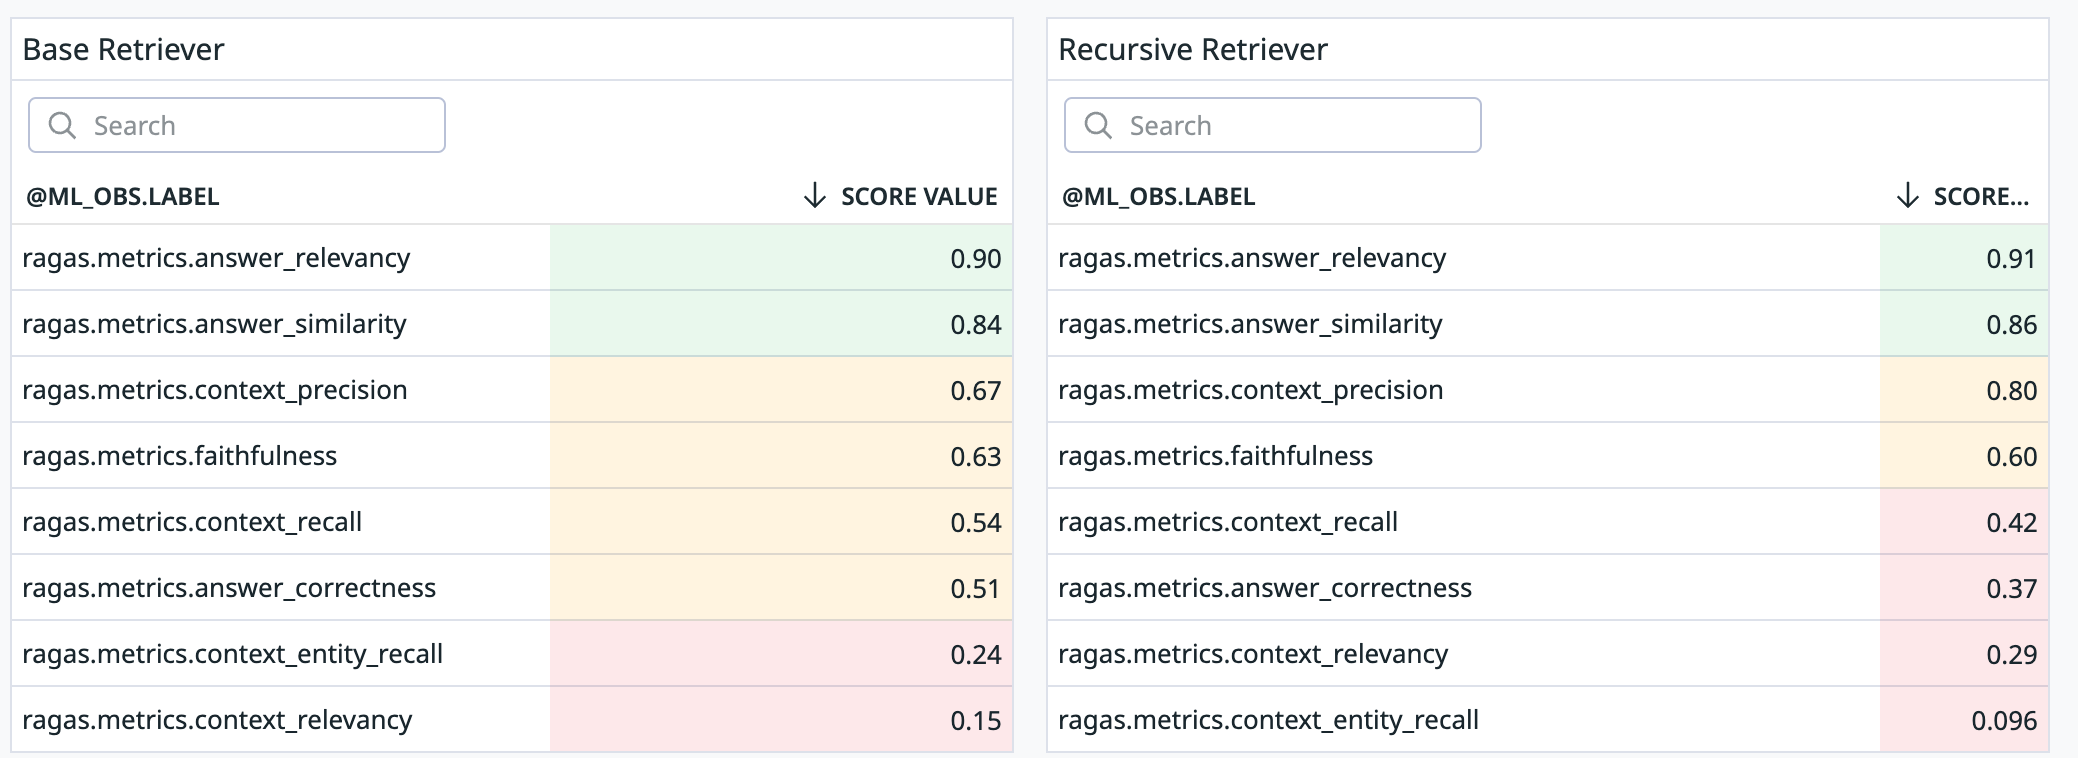
